# **[HW5] Language Model**
1. DataLoader
2. Model
3. Trainer
4. Generation

이번 실습에서는 RNN기반의 Language Model를 구현해서 텍스트를 직접 생성해보는 실습을 진행해보겠습니다.

- dataset: WikiText2 (https://github.com/pytorch/examples/tree/master/word_language_model/data/wikitext-2)
- model: LSTM




## Import packages

런타임의 유형을 변경해줍니다.

상단 메뉴에서 [런타임]->[런타임유형변경]->[하드웨어가속기]->[GPU]

변경 이후 아래의 cell을 실행 시켰을 때, torch.cuda.is_avialable()이 True가 나와야 합니다.



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
print(torch.__version__)
print(torch.cuda.is_available())

1.12.0+cu113
True


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import tqdm
import os
import random
import time
import datetime

# for reproducibility
random.seed(1234)
np.random.seed(1234)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 1. DataLoader

이전의 실습들에서 사용한것과 마찬가지로, PyTorch style의 dataloader를 먼저 만들어 두겠습니다.

### Dataset

저희가 이번 실습에서 사용할 데이터셋은 Wikipedia에 있는 영문 글들을 가져온 WikiTree dataset입니다.
저희가 불러올 데이터는 가장 작은 WikiTree dataset에서 자주 사용되지 않는 단어나 영어가 아닌 단어들은 <unk>으로 이미 전처리가 되어있습니다.

In [3]:
import urllib
with urllib.request.urlopen('https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/02-intermediate/language_model/data/train.txt') as f:
    data = f.readlines()

In [4]:
print('num_sentence:',len(data))
data[100]

num_sentence: 42068


b" plans that give advertisers discounts for maintaining or increasing ad spending have become permanent <unk> at the news <unk> and underscore the fierce competition between newsweek time warner inc. 's time magazine and <unk> b. <unk> 's u.s. news & world report \n"

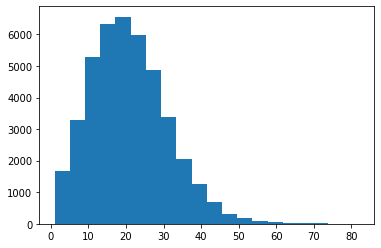

In [5]:
seq_length_list = []
for line in data:
    seq_length_list.append(len(line.split()))

counts, bins = np.histogram(seq_length_list, bins=20)
plt.hist(bins[:-1], bins, weights=counts)
plt.show()

데이터에 있는 문장 길이들의 histogram을 볼 때 대부분의 data의 문장 길이가 50에 미치지 못하기 때문에 \\
model에 집어넣을 최대 문장 길이를 50으로 세팅해두도록 하겠습니다.

In [6]:
max_seq_len = 50

### Build Dictionary

먼저 text 데이터를 모델에 넣어주기 위해서는 text에 존재하는 단어들을 index로 변환해주어야 합니다.

이를 위해서는 단어를 index로 변환해주는 word2idx dictionary와 다시 index를 단어로 변환해주는 idx2word dictionary를 만들어야 합니다.


In [7]:
def build_dictionary(data, max_seq_len):
    word2idx = {}
    idx2word = {}
    ## Build Dictionary
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1
    idx2word[0] = '<pad>'
    idx2word[1] = '<unk>'
    idx = 2
    for line in data:
        words = line.decode('utf-8').split()
        words = words[:max_seq_len]        
        ### Build Dictionary to convert word to index and index to word
        ### YOUR CODE HERE (~ 5 lines)
        for word in words:
            if word not in word2idx:
                word2idx[word] = idx
                idx2word[idx] = word
                idx += 1

    return word2idx, idx2word

word2idx, idx2word = build_dictionary(data, max_seq_len)

In [8]:
if len(word2idx) == len(idx2word) == 10000:
    print("Test Passed!")
else:
    raise AssertionError

Test Passed!


### Preprocessing

이제 앞서 만든 dictionary를 이용해서 text로된 데이터셋을 index들로 변환시키겠습니다.

In [9]:
def preprocess(data, word2idx, idx2word, max_seq_len):
    tokens = []
    for line in data:
        words = line.decode('utf-8').split()
        words = words[:max_seq_len]
        ### Convert dataset with tokens
        ### For each line, append <pad> token to match the number of max_seq_len
        ### YOUR CODE HERE (~ 4 lines)
        words += ['<pad>']*(max_seq_len - len(words))
        for word in words:
            token = word2idx[word]
            tokens.append(token)

    return tokens

tokens = preprocess(data, word2idx, idx2word, max_seq_len)

In [10]:
if len(tokens) == 2103400:
    print("Test Passed!")
else:
    raise AssertionError

Test Passed!


이제 전처리된 Token들을 문장 단위의 배열로 변환시켜 두겠습니다.

In [11]:
tokens = np.array(tokens).reshape(-1, max_seq_len)
print(tokens.shape)
tokens[100]

(42068, 50)


array([745,  93, 746, 739, 747, 181, 748, 467, 749, 740, 750, 154, 751,
       752,   1, 160,  32, 753,   1,  48, 754,  32, 755, 756, 757, 728,
       555, 758,  99, 119, 555, 733,  48,   1, 759,   1, 119, 237, 753,
       230, 760, 347,   0,   0,   0,   0,   0,   0,   0,   0])

### DataLoader

이제 전처리된 dataset을 활용하여 PyTorch style의 dataset과 dataloader를 만들도록 하겠습니다.

Token형태의 데이터를 PyTorch 스타일의 dataset으로 만들 때 주의할 점은, 추후 embedding matrix에서 indexing을 해주기 위해서 각 token이 LongTensor 형태로 정의되어야 한다는 점입니다.

In [12]:
class LMDataset(torch.utils.data.Dataset):
    def __init__(self, tokens):
        super(LMDataset, self).__init__()
        self.PAD = 0
        self.UNK = 1
        self.tokens = tokens
        self._getitem(2)

    def _getitem(self, index):
        X = self.tokens[index]
        y = np.concatenate((X[1:], [self.PAD]))

        X = torch.from_numpy(X).unsqueeze(0).long()
        y = torch.from_numpy(y).unsqueeze(0).long()

        return X, y

    def __getitem__(self, index):
        X = self.tokens[index]
        y = np.concatenate((X[1:], [self.PAD]))

        X = torch.from_numpy(X).long()
        y = torch.from_numpy(y).long()

        return X, y

    def __len__(self):
        return len(self.tokens)

In [13]:
batch_size = 64
dataset = LMDataset(tokens)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(len(dataset))
print(len(dataloader))

42068
658


# 2. Model

이번 section에서는 Language Modeling을 위한 Recurrent Model을 직접 만들어보도록 하겠습니다.

Standard한 Recurrent Neural Network (RNN) model은 vanishing gradient 문제에 취약하기 때문에, 이번 실습에서는 변형된 RNN구조인 LSTM model을 활용하도록 하겠습니다.


### LSTM

LSTM model의 전체적인 구조와 각 gate의 수식은 아래와 같습니다.

![](https://drive.google.com/uc?export=view&id=1n93tpNW55Xl4GxZNcJcbUVRhuNCGH38h)

![](https://drive.google.com/uc?export=view&id=1nH9U5iD9cO6OVVTbrx-LjypRvcWzbOCU)

LSTM의 자세한 동작방식이 궁금하신 분은 아래의 블로그를 참조해주세요.

https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [14]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        # input-gate
        self.Wi = nn.Linear(input_size + hidden_size, hidden_size)
        # forget-gate
        self.Wf = nn.Linear(input_size + hidden_size, hidden_size)
        # gate-gate
        self.Wg = nn.Linear(input_size + hidden_size, hidden_size)
        # output-gate
        self.Wo = nn.Linear(input_size + hidden_size, hidden_size)

        # non-linearity
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x, h_0, c_0):
        """
        Inputs
            input (x): [batch_size, input_size]
            hidden_state (h_0): [batch_size, hidden_size]
            cell_state (c_0): [batch_size, hidden_size]
        Outputs
            next_hidden_state (h_1): [batch_size, hidden_size]
            next_cell_state (c_1): [batch_size, hidden_size]    
        """
        h_1, c_1 = None, None
        input = torch.cat((x, h_0), 1)
        # Implement LSTM cell as noted above
        ### YOUR CODE HERE (~ 6 lines)
        i = self.sigmoid(self.Wi(input))
        f = self.sigmoid(self.Wf(input))
        g = self.tanh(self.Wg(input))
        o = self.sigmoid(self.Wo(input))
        c_1 = f * c_0 + i * g
        h_1 = o * self.tanh(c_1)

        return h_1, c_1

In [15]:
def test_lstm():
    batch_size = 2
    input_size = 5
    hidden_size = 3

    #torch.manual_seed(1234)
    lstm = LSTMCell(input_size ,hidden_size)
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.constant_(m.weight, 0.1)
            m.bias.data.fill_(0.01)
    lstm.apply(init_weights)

    x = torch.ones(batch_size, input_size)
    hx = torch.zeros(batch_size, hidden_size)
    cx = torch.zeros(batch_size, hidden_size)

    hx, cx = lstm(x, hx, cx)
    assert hx.detach().allclose(torch.tensor([[0.1784, 0.1784, 0.1784], 
                                              [0.1784, 0.1784, 0.1784]]), atol=2e-1), \
            f"Output of the hidden state does not match."
    assert cx.detach().allclose(torch.tensor([[0.2936, 0.2936, 0.2936], 
                                              [0.2936, 0.2936, 0.2936]]), atol=2e-1), \
            f"Output of the cell state does not match."

    print("==LSTM cell test passed!==")

test_lstm()

==LSTM cell test passed!==


## Language Model

이제, 위에서 정의한 LSTM Cell을 활용해서 아래와 같은 Langauge Model을 만들어보도록 하겠습니다.


![](https://drive.google.com/uc?export=view&id=1nMAbL-g31nERM44dgohA3k9Vj_92hIh-)

In [16]:
class LanguageModel(nn.Module):
    def __init__(self, input_size=64, hidden_size=64, vocab_size=10000):
        super(LanguageModel, self).__init__()
        
        self.input_layer = nn.Embedding(vocab_size, input_size)
        self.hidden_layer = LSTMCell(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, vocab_size)


    def forward(self, x, hx, cx, predict=False):
        """
        Inputs
            input (x): [batch_size]
            hidden_state (h_0): [batch_size, hidden_size]
            cell_state (c_0): [batch_size, hidden_size]
            predict: whether to predict and sample the next word
        Outputs
            output (ox): [batch_size, hidden_size]
            next_hidden_state (h_1): [batch_size, hidden_size]
            next_cell_state (c_1): [batch_size, hidden_size]    
        """
        x = self.input_layer(x)
        hx, cx = self.hidden_layer(x, hx, cx)
        ox = self.output_layer(hx)

        if predict == True:
            probs = F.softmax(ox, dim=1)
            # torch distribution allows sampling operation
            # see https://pytorch.org/docs/stable/distributions.html
            dist = torch.distributions.Categorical(probs)
            ox = dist.sample()

        return ox, hx, cx  

# 3. Trainer

자 이제 위에서 구현한 dataloader와 langauge model을 활용해서 모델의 학습을 진행해보도록 하겠습니다.


In [17]:
class Trainer():
    def __init__(self, 
                 word2idx, 
                 idx2word,
                 dataloader, 
                 model, 
                 criterion,
                 optimizer, 
                 device):
        """
        dataloader: dataloader
        model: langauge model
        criterion: loss function to evaluate the model (e.g., BCE Loss)
        optimizer: optimizer for model
        """
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.dataloader = dataloader
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        
    def train(self, epochs = 1):
        self.model.to(self.device)
        start_time = time.time()
        for epoch in range(epochs):
            losses = []
            for iter, (x_batch, y_batch) in tqdm.tqdm(enumerate(self.dataloader)):
                self.model.train()
                
                batch_size, max_seq_len = x_batch.shape
                x_batch = x_batch.to(self.device)
                y_batch = y_batch.to(self.device)

                # initial hidden-states
                hx = torch.zeros(batch_size, hidden_size).to(self.device)
                cx = torch.zeros(batch_size, hidden_size).to(self.device)

                # Implement LSTM operation
                ox_batch = []
                # Get output logits for each time sequence and append to the list, ox_batch
                # YOUR CODE HERE (~ 4 lines)
                for s_idx in range(max_seq_len):
                    x = x_batch[:, s_idx]
                    ox, hx, cx = self.model(x, hx, cx)
                    ox_batch.append(ox)
                # outputs are ordered by the time sequence
                ox_batch = torch.cat(ox_batch).reshape(max_seq_len, batch_size, -1)
                ox_batch = ox_batch.permute(1,0,2).reshape(batch_size*max_seq_len, -1)
                y_batch = y_batch.reshape(-1)

                self.model.zero_grad()
                loss = self.criterion(ox_batch, y_batch)
                loss.backward()
                self.optimizer.step()
                losses.append(loss.item())

            end_time = time.time() - start_time
            end_time = str(datetime.timedelta(seconds=end_time))[:-7]
            print('Time [%s], Epoch [%d/%d], loss: %.4f'
                  % (end_time, epoch+1, epochs, np.mean(losses)))
            if epoch % 5 == 0:
                generated_sentences = self.test()
                print('[Generated Sentences]')
                for sentence in generated_sentences:
                    print(sentence)
            
    def test(self):
        # Test model to genereate the sentences
        self.model.eval()
        num_sentence = 5
        max_seq_len = 50

        # initial hidden-states
        outs = []
        x = torch.randint(0, 10000, (num_sentence,)).to(self.device)
        hx = torch.zeros(num_sentence, hidden_size).to(self.device)
        cx = torch.zeros(num_sentence, hidden_size).to(self.device)

        outs.append(x)
        with torch.no_grad():
            for s_idx in range(max_seq_len-1):
                x, hx, cx = self.model(x, hx, cx, predict=True)
                outs.append(x)
        outs = torch.cat(outs).reshape(max_seq_len, num_sentence)
        outs = outs.permute(1, 0)
        outs = outs.detach().cpu().numpy()

        sentences = []
        for out in outs:
            sentence = []
            for token_idx in out:
                word = self.idx2word[token_idx]
                sentence.append(word)
            sentences.append(sentence)
       
        return sentences

In [18]:
for iter,(x_batch,y_batch) in (enumerate(dataloader)):
    print(x_batch.shape)

torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([6

In [19]:
lr = 1e-2
input_size = 128
hidden_size = 128
batch_size = 256

dataset = LMDataset(tokens)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = LanguageModel(input_size=input_size, hidden_size=hidden_size)
# NOTE: you should use ignore_index to ignore the loss from predicting the <PAD> token
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=lr)
device = torch.device('cuda')

trainer = Trainer(word2idx = word2idx,
                  idx2word = idx2word,
                  dataloader=dataloader, 
                  model = model,
                  criterion=criterion,
                  optimizer = optimizer,
                  device=device)

trainer.train(epochs=50)

165it [00:19,  8.49it/s]


Time [0:00:19], Epoch [1/50], loss: 6.0941
[Generated Sentences]
['bike', 'counted', 'would', 'require', '$', 'N', 'billion', 'from', '$', 'N', 'billion', 'plants', 'to', 'more', 'soon', 'off', 'the', 'two', 'stop', 'the', 'next', 'practices', 'takes', 'yesterday', 'her', 'chapter', 'N', 'staff', 'unit', 'after', 'the', 'smallest', 'businesses', "'s", 'board', 'suggested', 'who', 'force', 'so', 'commons', 'can', 'use', 'a', 'imported', 'action', 'on', 'waertsilae', 'up', 'on', 'a']
['push', 'command', "'s", 'greenwich', 'exchange', 'collateral', 'subsidiary', 'has', 'grew', 'N', 'subordinated', 'a', 'major', 'investment', 'during', "'s", 'mr.', 'savaiko', 'that', 'long-term', 'the', 'stock', 'to', '<unk>', 'teams', 'furniture', '<unk>', 'either', 'operating', 'analysts', 'say', 'it', 'is', 'under', 'by', 'the', 'bleak', 'house', 'co.', 'says', 'a', 'comprehensive', 'price', 'letter', 'to', 'a', 'shareholders', 'from', 'manufacturing', 'stocks']
['hartford', 'construction', 'of', 'syste

165it [00:16, 10.10it/s]


Time [0:00:35], Epoch [2/50], loss: 5.2191


165it [00:16, 10.16it/s]


Time [0:00:52], Epoch [3/50], loss: 4.8991


165it [00:16,  9.83it/s]


Time [0:01:08], Epoch [4/50], loss: 4.6941


165it [00:16, 10.25it/s]


Time [0:01:25], Epoch [5/50], loss: 4.5368


165it [00:16, 10.23it/s]


Time [0:01:41], Epoch [6/50], loss: 4.4092
[Generated Sentences]
['rated', 'single-a-2', 'of', 'trading', 'the', 'small', 'tv', 'buy-out', 'selling', '<unk>', 'vehicles', 'without', 'providing', 'huge', 'amounts', 'over', 'to', '$', 'N', 'billion', 'of', 'united', 'a', 'second', 'agency', 'was', 'proposed', 'reflecting', 'lower', 'prices', 'for', 'the', 'operation', 'of', 'the', 'new', 'york', 'state', 'department', "'s", 'record', 'stock', 'exchange', 'in', 'new', 'york', 'investors', 'and', 'defeated', 'quotron']
['aid', 'immediately', 'mips', 'says', 'the', 'group', "'s", 'extraordinary', 'strength', 'of', 'bad', 'companies', 'in', 'the', 'club', "'s", 'most', 'consumer', 'electronics', 'has', 'refused', 'to', 'the', 'expected', 'interest', 'in', 'the', 'valley', 'with', 'record', 'and', 'apartments', 'and', 'dialysis', 'patients', 'a', 'unit', 'of', 'merksamer', '&', '<unk>', 'ltd.', 'has', 'been', '<unk>', 'very', 'setting', 'up', 'with', 'weaker']
['vessels', 'some', 'details', '

165it [00:16, 10.27it/s]


Time [0:01:57], Epoch [7/50], loss: 4.3021


165it [00:16, 10.25it/s]


Time [0:02:13], Epoch [8/50], loss: 4.2084


165it [00:16, 10.23it/s]


Time [0:02:29], Epoch [9/50], loss: 4.1286


165it [00:16, 10.12it/s]


Time [0:02:45], Epoch [10/50], loss: 4.0591


165it [00:16, 10.28it/s]


Time [0:03:01], Epoch [11/50], loss: 3.9953
[Generated Sentences]
['angels', '<unk>', 'a.', 'bologna', 'president', '<unk>', '<unk>', 'calif.', 'has', 'interests', 'in', '<unk>', 'language', 'and', 'objectives', 'driving', 'premier', 'or', 'the', 'kansas', 'city', 'to', 'repair', 'the', 'department', "'s", 'first', 'test', 'base', 'news', 'and', 'to', 'calm', 'and', 'the', 'two', '<unk>', 'in', 'N', 'cases', 'now', 'that', 'only', '$', 'N', 'a', 'year', 'both', 'profit', 'of']
['hotels', 'revenue', 'friday', 'earlier', 'fueled', 'by', 'strong', 'sales', 'of', 'about', '$', 'N', 'million', 'positions', 'the', 'official', 'indianapolis', 'listed', 'in', 'the', 'british', 'operations', 'of', 'mutual', 'funds', 'and', 'are', 'extremely', 'attractive', 'in', 'the', 'expenses', 'bring', 'even', 'changing', 'in', 'the', 'day', 'down', 'N', 'N', 'of', 'buck', 'in', 'tonight', '<unk>', 'N', 'late', 'at', 'one']
['repurchase', 'diabetics', 'based', 'in', 'iowa', 'for', 'example', 'he', 'adds', '

165it [00:16, 10.24it/s]


Time [0:03:18], Epoch [12/50], loss: 3.9369


165it [00:16, 10.26it/s]


Time [0:03:34], Epoch [13/50], loss: 3.8859


165it [00:16, 10.18it/s]


Time [0:03:50], Epoch [14/50], loss: 3.8408


165it [00:16, 10.18it/s]


Time [0:04:06], Epoch [15/50], loss: 3.7980


165it [00:16, 10.27it/s]


Time [0:04:22], Epoch [16/50], loss: 3.7598
[Generated Sentences]
['appointment', 'pro-choice', 'testing', 'could', "n't", 'have', 'justified', 'a', 'briefing', 'book', 'holding', 'about', 'the', 'engineering', 'company', 'the', 'ruling', 'service', 'in', 'june', '<unk>', 'entertainment', 'inc', 'a', 'joint', '<unk>', 'to', 'cancel', 'responsible', 'for', 'jan.', 'N', 'with', 'the', 'amount', 'of', 'other', 'common', 'to', 'face', 'the', 'company', 'to', 'a', 'flight', 'which', 'will', 'be', 'remembered', 'at']
['faa', 'also', 'said', 'this', 'influenced', 'the', 'spokesman', 'does', 'it', 'could', 'get', 'it', 'much', 'too', 'where', 'coke', 'can', 'accept', 'it', 'because', 'of', 'its', 'appointment', 'to', 'defer', 'its', 'board', 'meeting', 'in', 'new', 'york', '<unk>', 'with', '<unk>', 'cards', 'inc', 'seeking', 'to', 'waive', 'more', 'assistance', 'as', 'the', 'senate', 'banking', 'committee', 'rep.', 'stephen', 'neal', 'v.']
['third-largest', 'rand', 'advanced', 'N', 'N', 'to', 

165it [00:16, 10.24it/s]


Time [0:04:38], Epoch [17/50], loss: 3.7251


165it [00:16,  9.98it/s]


Time [0:04:55], Epoch [18/50], loss: 3.6924


165it [00:16, 10.21it/s]


Time [0:05:11], Epoch [19/50], loss: 3.6620


165it [00:16, 10.25it/s]


Time [0:05:27], Epoch [20/50], loss: 3.6347


165it [00:16, 10.20it/s]


Time [0:05:43], Epoch [21/50], loss: 3.6098
[Generated Sentences]
['abruptly', 'resolved', 'both', 'sides', 'came', 'to', 'the', 'institution', 'the', '<unk>', 'movement', 'has', 'introduced', 'in', 'february', 'a', 'modest', 'appreciation', 'machine', 'with', 'a', 'merchant', 'bank', 'promotional', 'center', 'about', 'interpublic', 'group', '&', 'co.', 'narrowed', 'the', 'fund', 'by', 'the', 'company', "'s", 'sharp', 'parent', 'company', 'provided', 'for', 'the', 'quarter', 'no', 'refinancing', 'cash', 'reserves', 'against', 'ford']
['butter', 'cos.', 'little', 'damage', 'at', 'a', 'time', 'when', 'it', "'s", 'asked', 'a', 'week', 'in', 'the', 'wall', 'street', 'journal', 'automotive', 'news', 'a', '<unk>', '<unk>', 'concern', 'said', 'its', 'research', 'pact', 'was', '$', 'N', 'million', 'in', 'the', 'fourth', 'quarter', 'of', 'N', 'billion', 'yen', 'or', 'eight', 'cents', 'a', 'share', 'for', 'its', 'previous', 'fiscal', 'year']
['talks', 'between', 'robert', 's.', 'lee', 'told', 'b

165it [00:16, 10.25it/s]


Time [0:06:00], Epoch [22/50], loss: 3.5860


165it [00:16, 10.24it/s]


Time [0:06:16], Epoch [23/50], loss: 3.5642


165it [00:16, 10.27it/s]


Time [0:06:32], Epoch [24/50], loss: 3.5441


165it [00:16, 10.01it/s]


Time [0:06:48], Epoch [25/50], loss: 3.5253


165it [00:16, 10.22it/s]


Time [0:07:04], Epoch [26/50], loss: 3.5075
[Generated Sentences]
['distinctive', 'art', 'contel', 'corp.', 'agreed', 'to', 'merge', 'with', '$', 'N', 'billion', 'in', 'short-term', 'u.s.', 'insurance', 'policies', 'helped', 'change', 'its', 'pilots', 'said', 'a', 'gain', 'from', 'the', 'company', 'does', "n't", 'received', 'any', 'selling', 'pressure', 'in', 'overhead', 'costs', 'of', 'a', 'dispute', 'between', 'the', 'first', 'and', 'refunding', 'of', 'its', 'common', 'stock', 'in', 'the', 'big']
['apparel', 'ups', 'told', 'the', 'committee', 'salespeople', 'took', 'before', 'gen.', 'noriega', 'would', 'permit', 'many', 'of', 'its', '<unk>', 'drugs', 'as', 'the', 'largest', 'cereal', 'maker', 'says', 'mr.', 'bell', "'s", 'boston', 'safe', 'deposit', 'u.s.', 'inc.', "'", 'loss', 'narrowed', 'to', 'the', 'N', 'price', 'from', 'olympia', '&', 'york', 'developments', 'ltd.', "'s", 'biggest', 'competitor', 'and', 'in', 'N']
['museum', 'sheet', 'connection', 'amex', 'to', 'government', 'th

165it [00:16, 10.27it/s]


Time [0:07:20], Epoch [27/50], loss: 3.4913


165it [00:16, 10.25it/s]


Time [0:07:37], Epoch [28/50], loss: 3.4741


165it [00:16, 10.22it/s]


Time [0:07:53], Epoch [29/50], loss: 3.4594


165it [00:16, 10.26it/s]


Time [0:08:09], Epoch [30/50], loss: 3.4485


165it [00:16, 10.26it/s]


Time [0:08:25], Epoch [31/50], loss: 3.4349
[Generated Sentences]
['eidsmo', 'my', 'convertible', 'ownership', 'and', 'defense', 'work', 'on', 'eastern', 'predicted', 'that', 'in', 'september', 'orders', 'for', 'the', 'western', 'six', 'latest', 'set', 'stocks', 'were', 'at', 'about', 'half', 'had', 'a', 'strong', 'identity', 'company', 'will', 'likely', 'be', 'effective', 'enough', 'to', 'rise', 'the', 'value', 'of', 'its', 'coors', 'brewing', 'and', 'leather', 'accessories', 'since', '<unk>', '<unk>', 'creek']
['beam', 'draw', 'held', 'viewers', '<unk>', 'already', 'had', 'no', 'objective', '<unk>', 'involved', 'in', 'recent', 'years', 'did', "n't", 'have', 'it', 'anymore', 'there', 'is', 'you', 'regarding', 'that', 'his', '<unk>', 'champion', 'writer', 'who', 'became', '<unk>', 'the', 'latest', 'for', 'the', 'plans', 'were', 'he', 'owned', 'students', 'is', 'doing', 'better', 'enough', 'to', 'own', 'is', 'the', 'internal', 'task']
['hitting', 'places', 'she', 'could', "n't", 'be', '

165it [00:16, 10.20it/s]


Time [0:08:41], Epoch [32/50], loss: 3.4238


165it [00:16, 10.05it/s]


Time [0:08:58], Epoch [33/50], loss: 3.4117


165it [00:16, 10.24it/s]


Time [0:09:14], Epoch [34/50], loss: 3.4035


165it [00:16, 10.20it/s]


Time [0:09:30], Epoch [35/50], loss: 3.3910


165it [00:16, 10.22it/s]


Time [0:09:46], Epoch [36/50], loss: 3.3839
[Generated Sentences]
['exemption', 'tougher', 'halloween', 'presents', 'nothing', 'with', 'crimes', 'mr.', '<unk>', 'of', 'official', '<unk>', 'during', 'commute', 'hours', 'later', 'and', '<unk>', 'insist', 'they', "'re", 'exceeding', 'risk', 'because', 'the', 'selling', 'of', 'many', 'foreign', 'behavior', 'bases', 'will', 'not', 'be', 'effective', 'only', 'last', 'year', 'since', 'the', 'bay', 'bridge', 'accused', 'of', 'sexual', '<unk>', 'shot', 'in', 'subjects', 'and']
['roll', 'prevented', 'legislation', 'prosecutors', 'may', 'cushion', 'at', 'the', 'time', 'he', 'feared', 'for', 'elections', 'the', 'buyer', 'are', 'replaced', 'by', 'a', 'house-senate', 'conference', 'if', 'nbc', 'raise', 'N', 'results', 'since', 'the', 'early', '1950s', 'when', 'citicorp', 'and', 'technically', 'an', 'attempt', 'to', '<unk>', 'its', 'links', 'with', 'the', 'dividend', 'to', 'N', 'N', 'of', 'meridian', "'s", 'debt']
['flat-rolled', 'mighty', '<unk>', '

165it [00:16, 10.26it/s]


Time [0:10:02], Epoch [37/50], loss: 3.3757


165it [00:16, 10.24it/s]


Time [0:10:18], Epoch [38/50], loss: 3.3667


165it [00:15, 10.32it/s]


Time [0:10:34], Epoch [39/50], loss: 3.3596


165it [00:16, 10.05it/s]


Time [0:10:51], Epoch [40/50], loss: 3.3513


165it [00:16, 10.21it/s]


Time [0:11:07], Epoch [41/50], loss: 3.3479
[Generated Sentences]
['distribute', '<unk>', 'could', 'get', 'their', 'senators', '<unk>', 'as', 'an', 'officer', 'of', 'the', 'australian', 'department', 'of', 'housing', 'for', 'two', 'days', 'in', 'games', 'also', 'said', 'while', 'no', 'such', 'another', 'names', 'of', 'this', 'big', 'cyclical', 'economy', 'and', 'boasts', 'that', 'mr.', 'gorbachev', 'they', 'maintain', 'new', 'companies', '<unk>', 'by', 'congress', 'applied', 'to', 'deny', 'it', 'will']
['publisher', 'weaknesses', 'chief', 'announced', 'that', 'he', 'was', 'cut', 'he', 'says', 'the', 'educational', 'limitations', 'of', 'output', 'supplies', 'but', 'the', 'likes', 'of', 'which', 'include', 'other', 'steel', 'products', 'construction', 'furukawa', 'already', '<unk>', 'earlier', 'this', 'year', 'for', 'example', 'could', 'pose', 'a', 'new', 'role', 'to', 'make', 'the', 'job', 'of', 'those', 'in', 'the', 'u.s.', 'when', 'compensation']
['deficiencies', 'vigorously', 'badly'

165it [00:16, 10.27it/s]


Time [0:11:23], Epoch [42/50], loss: 3.3431


165it [00:16, 10.20it/s]


Time [0:11:39], Epoch [43/50], loss: 3.3353


165it [00:16, 10.24it/s]


Time [0:11:55], Epoch [44/50], loss: 3.3294


165it [00:16, 10.27it/s]


Time [0:12:12], Epoch [45/50], loss: 3.3247


165it [00:16, 10.25it/s]


Time [0:12:28], Epoch [46/50], loss: 3.3211
[Generated Sentences]
['tanks', 'showed', 'that', 'the', 'house', 'may', 'help', 'suffer', 'in', 'the', 'health', 'and', 'planes', 'and', 'readily', 'take', 'back', 'from', 'more', 'than', 'competing', 'it', 'appropriate', 'who', 'champion', 'insurance', 'is', 'a', '<unk>', 'of', 'a', 'role', 'in', 'u.s.', 'officials', 'of', 'researchers', 'which', 'without', 'asking', 'within', 'a', 'revolution', '<unk>', 'from', 'church', 'has', 'been', 'almost', 'impossible']
['sexual', 'metals', 'is', 'increasing', 'it', 'ordered', 'soon', 'because', 'the', 'likelihood', 'that', 'it', 'sure', 'the', 'pilots', 'consistently', 'had', 'major', 'liability', 'because', 'of', 'two', 'votes', 'in', 'five', 'cases', 'had', '<unk>', 'loose', '<unk>', 'in', 'sharply', 'charges', 'over', 'the', 'her', 'year', 'says', 'raymond', 'hyman', 'a', 'real', 'seven-year', '<unk>', 'and', 'the', 'ground', 'big', 'board', 'members']
['unstable', 'comedy', 'contel', 'whose', 't

165it [00:16, 10.28it/s]


Time [0:12:44], Epoch [47/50], loss: 3.3151


165it [00:16, 10.11it/s]


Time [0:13:00], Epoch [48/50], loss: 3.3130


165it [00:16, 10.25it/s]


Time [0:13:16], Epoch [49/50], loss: 3.3091


165it [00:16, 10.28it/s]

Time [0:13:32], Epoch [50/50], loss: 3.3035


생성된 텍스트의 퀄리티는 어떤가요? 

앞으로 딥러닝 강의가 끝나면 자연어처리 강좌에서 텍스트 처리에 적합한 전처리 과정, 모델구조들을 본격적으로 배우시게 될것입니다.

# References

1. https://github.com/pytorch/examples/tree/master/word_language_model
2. https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/02-intermediate/language_model